# Demonstration on 6x6 images

In [34]:
import numpy as np

print(np.random.choice(2, size=(4,)))

[1 0 0 0]


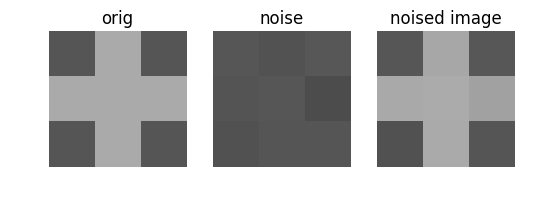

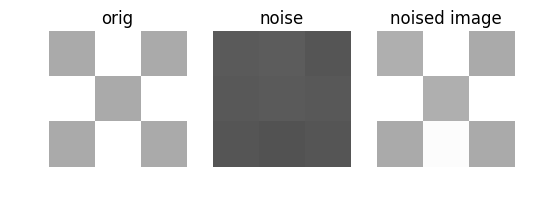

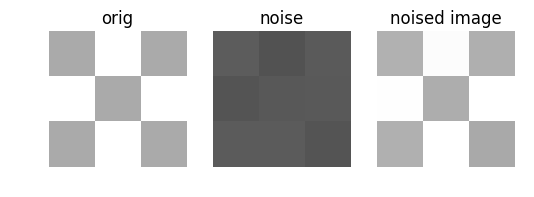

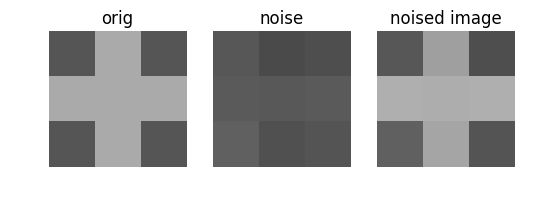

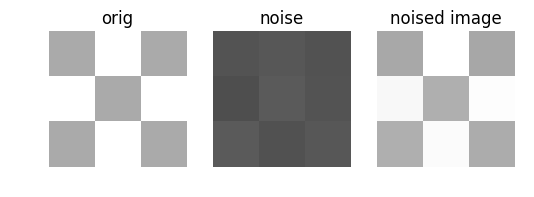

In [112]:
### import numpy as np
import matplotlib.pyplot as plt
import math


num_classes = 2
image_size = 3
N = 10
num_samples_to_print = 5
sigma_X = 0.05

class_descriptions = [
    {
        'sprite': [
            [0,1,0],
            [1,1,1],
            [0,1,0]
        ],
        'sprite_x': 0,
        'sprite_y': 0
    },
    {
        'sprite': [
            [1,1,1],
            [1,0,1],
            [1,1,1]
        ],
        'sprite_x': 0,
        'sprite_y': 0
    },
    {
        'sprite': [
            [1,0,0],
            [1,1,0],
            [1,1,1]
        ],
        'sprite_x': 0,
        'sprite_y': 3
    },
    {
        'sprite': [
            [1,1,1],
            [0,1,0],
            [0,1,0]
        ],
        'sprite_x': 3,
        'sprite_y': 3
    }
]

def class_descriptions_to_class_pics():
    class_pics = []
    for i, desc in enumerate(class_descriptions):
        if i >= num_classes:
            break
        pic = np.zeros((image_size, image_size), dtype=np.float32)
        for dx in range(3):
            for dy in range(3):
                if desc['sprite'][dy][dx] == 1:
                    pic[desc['sprite_y'] + dy, desc['sprite_x'] + dx] = 1.0
        class_pics.append(pic)
    return class_pics

class_pics = class_descriptions_to_class_pics()
# print(class_pics)

def print_images(titles, images):
    plt.figure(1)
    num_figures = len(images)
    for i, image in enumerate(images):
        image_size = image.shape[0]
        image_min = np.min(image)
        image_max = np.max(image)
        image_min = -1
        image_max = 2
        image_range = image_max - image_min
        image = np.maximum(image_min, image)
        image = np.minimum(image_max, image)
        image = (image - image_min) / image_range
        image_rgb = np.zeros((image_size, image_size, 3), dtype=np.float32)
        image_rgb[:,:,0] = image
        image_rgb[:,:,1] = image
        image_rgb[:,:,2] = image
        plt.subplot(1, num_figures, i + 1)
        plt.imshow(image_rgb, interpolation='nearest')
        plt.axis('off')
        plt.title(titles[i])
    plt.show()

def draw_samples(N, class_pics):
    samples = []
    samples_to_print = set(np.random.choice(N, (num_samples_to_print,), replace=False))
    for n in range(N):
        image = np.zeros((image_size, image_size), dtype=np.float32)
        features = np.random.choice(2, size=(num_classes,))
#         print(features)
        for k, v in enumerate(features):
            if v == 1:
                image += class_pics[k]
        image_orig = np.copy(image)
#         print_image(image)

        noise = np.random.randn(image_size, image_size).astype(np.float32) * sigma_X
#         print_image(noise)

        image += noise
        if n in samples_to_print:
#             print(n)
            print_images(['orig', 'noise', 'noised image'], [image_orig, noise, image])

        samples.append(image)
    return samples

samples = draw_samples(N, class_pics)


In [121]:
Z_columns = []
column = np.random.choice(2, (N,))
Z_columns.append(column)
K_plus = len(Z_columns)
# print(Z_columns)
M = []
M.append(np.sum(Z_columns[0]))
# print('M', M)

sigma_A = 0.5
sigma_X = 1.7
alpha = 1.0

for it in range(10):
    for n in range(N):
        k = 0
        while k < len(Z_columns):
            column = Z_columns[k]
            m = M[k]
            if m == 1 and column[n] == 1:
                # means that m_{-i} is zero
                # so, delete the column
                del Z_columns[k]
                del M[k]
                k -= 1
            else:
                # M_{-i} > 0
                # what do we do now???
            k += 1

[array([0, 0, 0, 1, 0, 1, 0, 1, 0, 0])]
M [3]


At this point, I looked at the tutorial's equation 22.  But there's a proportional-to sign, $\propto$.  How to handle this?  Since I'm not trying to do this research from scratch, just reproduce/understand the existing research, I reached out to Mr Google, to look for more explanations.  I found the following video, from Finale Doshi-Velez, which I'm going to interlude out to now

## Interlude: presentation "Accelerated Gibbs Sampling for the Indian Buffet Process", Doshi-Velez, Ghahramani

It's here: http://videolectures.net/icml09_doshi_velez_ags/

Corresponding slides: http://videolectures.net/site/normal_dl/tag=47975/icml09_doshi_velez_ags_01.pdf

It's still advised by Ghahramani, but the student is now Doshi-Velez.  Going through the lecture:

Finale notes that, for model:

$$\mathbf{X} = \mathbf{Z}\mathbf{A} + \mathbf{E}$$

- can compute $P(\mathbf{Z} \mid \mathbf{Z})$, but expensive
- can compute $P(\mathbf{A} \mid \mathbf{X}, \mathbf{Z})$ (just a linear expression (?))
- cannot compute $P(\mathbf{Z)}, \mathbf{A} \mid \mathbf{Z})$

For this lecture, Doshi-Velez is going to target putting a window over the data, $\mathbf{X}$, and $\mathbf{Z}$, so they will only consider a window of $W$ points at a time, splitting each matrix into:

$$\mathbf{X} =
\begin{bmatrix}
\mathbf{X}_{-W} \\
\mathbf{X}_{W} \\
\end{bmatrix}$$

and:

$$\mathbf{Z} =
\begin{bmatrix}
\mathbf{Z}_{-W} \\
\mathbf{Z}_{W} \\
\end{bmatrix}$$

(where here the data points are arranged as one row per data point, and the features are the columns).

They do this, because they want to target large datasets.

Then, Doshi-Velez goes over the following two principle sampling schemes:

### Uncollapsed sampling

![](img/basicsampling_1.png)

![](img/basicsampling_2.png)

![](img/basicsampling_A.png)

Uncollapsed sampling:

- each iteration is quick (or should be, otherwise we have other issues to deal with)
- but mixing very slow

### Collapsed sampling

![](img/collapsed_gibbs.png)

- mixing fast
- but each iteration can be slow/challenging, and
- we lose the independences between the samples and latent features within the window, and outside of the window

### Their idea: Keep a posterior on A

![](img/acceleratedsampling.png)

- data samples and latent variables within the window remain independent of those outside of it
- (conditional on the posterior of A)


Then, Doshi-Velez goes over the maths of the accelerated sampling:

Consider one element, and here the notation has changed from $w$/$-w$ to $n$/$-n$ (edit in retrospect: the notation changed, because here $n$ represents a single element, whereas $w$ represents a window over multiple elements):

$$P(z_{nk} = 1 \mid Z_{-nk}, \mathbf{X})$$
&nbsp;
$$\propto P(z_{nk} \mid \mathbf{Z}_{-nk})\,P(\mathbf{X} \mid \mathbf{Z})$$

So, it took me a while to figure out why this statement is proportionality, not equality.  Finally I realized we can do, following the hint about 'bayes rule' in the slides:

$$P(z_{nk} = 1 \mid \mathbf{Z}_{-nk}, \mathbf{X})
= 
\frac{
   P(\mathbf{X} \mid z_{nk} = 1, \mathbf{Z}_{-nk})\, P(z_{nk} = 1 \mid \mathbf{Z}_{-nk})
}
{
   P(\mathbf{X} \mid \mathbf{Z}_{-nk})
}$$
&nbsp;
$$\propto P(z_{nk} \mid \mathbf{Z}_{-nk})\,P(\mathbf{X} \mid \mathbf{Z})$$

as stated.

Continuing, by writing $P(\mathbf{X} \mid \mathbf{Z})$ as a marginalization over $\mathbf{A}$:

$$=
P(z_{nk} \mid \mathbf{Z}_{-nk})
\int_A P(\mathbf{X} \mid \mathbf{Z}, \mathbf{A})\, P(\mathbf{A})\,d\mathbf{A}
$$

Factorizing over $\mathbf{X}_n$ and $\mathbf{X}_{-n}$:

$$
=
P(z_{nk} \mid \mathbf{Z}_{-nk})
\int_A P(\mathbf{X}_n \mid \mathbf{Z}_n, \mathbf{A})\, P(\mathbf{X}_{-n} \mid \mathbf{Z}_{-n}, \mathbf{A})\, P(\mathbf{A})\,d\mathbf{A}
$$


For this identity (or plausibly: proportionality):

$$
P(\mathbf{X}_{-n} \mid \mathbf{Z}_{-n}, \mathbf{A})
=
P(\mathbf{A} \mid \mathbf{Z}_{-n}, \mathbf{X}_{-n})
$$

... lets a try a few different things.  Let's try swapping $\mathbf{A}$ and $\mathbf{X}_{-n}$:

$$
P(\mathbf{X}_{-n} \mid \mathbf{Z}_{-n}, \mathbf{A})
=
\frac{P(\mathbf{A} \mid \mathbf{Z}_{-n}, \mathbf{X}_{-n}) \, P(\mathbf{X}_{-n} \mid \mathbf{Z}_{-n})}
  {P(\mathbf{A} \mid \mathbf{Z}_{-n})}
$$


## Interlude: revising graphical models

At this point, I realized that my knowledge of graphical models sucks, and started thinking them through from the start.  So, here goes.

### Meaning of removing conditioning variable?

So, the first thing I realized I didnt know is, what does it mean $P(z_nk=1 \mid \mathbf{Z}_{-nk})$?  How is this different / not different to $P(z_{nk} = 1 \mid \mathbf{Z}_{-nk}, \mathbf{X})$?

So, what I think is: for the network above, we can attempt to calculate $P(z_{nk} \mid \mathbf{Z}_{-nk})$, without a conditional dependence on $\mathbf{X}$.  It's a valid expression, and it has some possible answers, depending plausibly on different assumptions.  But basically, it means "if I know the other latent values, for sure, or at least, think I know them, and I dont know anything about the observed data $\mathbf{X}$, whats the probability for different values of $z_{nk}$?".

So, we could obtain an expression for $P(z_{nk} \mid \mathbf{Z}_{-nk})$.  It is/would be a perfectly valid probability distribution.  It would tell us the probability distribution over $z_{nk}$, given that we know nothing about the observed data.

But sometimes/often, we want the values of the observed data to influence the probability distribution of $z_{nk}$.  So, we want $P(z_{nk} \mid \mathbf{X}, \mathbf{Z}_{-nk})$.  This doesnt mean that $P(z_{nk} \mid \mathbf{Z}_{-nk})$ doesnt exist, and note that $P(z_{nk} \mid \mathbf{Z}_{-nk}, \mathbf{X})$ most certainly is not the same thing was $P(z_{nk} \mid \mathbf{Z}_{-nk})$.  This was my mistake for a while: thinking that $P(z_{nk} \mid \mathbf{Z}_{-nk})$ is either identical to $P(z_{nk} \mid \mathbf{Z}_{-nk}, \mathbf{X})$, or better than it, because it depends on fewer things.  In fact, having the dependency on $\mathbf{X}$ means that if we do know $\mathbf{X}$, or have a good estimate of it, then we will have a more precise/accurate/something estimate for the probability distribution of $z_{nk}$.  So, we actually in fact want to have the dependence on $\mathbf{X}$ in the probability distribution, in the case that we know $\mathbf{X}$.  And in this case, we do know $\mathbf{X}$; its one of the few/only things we actually know.



So when we write:

$$P(z_{nk} = 1 \mid \mathbf{Z}_{-nk}, \mathbf{X})
= 
\frac{
   P(\mathbf{X} \mid z_{nk} = 1, \mathbf{Z}_{-nk})\, P(z_{nk} = 1 \mid \mathbf{Z}_{-nk})
}
{
   P(\mathbf{X} \mid \mathbf{Z}_{-nk})
}
$$
&nbsp;

$$
= 
\frac{
   P(\mathbf{X} \mid \mathbf{Z})\, P(z_{nk} = 1 \mid \mathbf{Z}_{-nk})
}
{
   P(\mathbf{X} \mid \mathbf{Z}_{-nk})
}
$$


...the term $P(z_{nk} \mid \mathbf{Z}_{-nk})$, on the right hand side, is the probability distribution of $z_{nk}$, in the case that we know nothing about the observed data, and only know the values of the other latent variables.  I dont think it's a prior on $z_{nk}$, since it does depend on some other data values, albeit latent ones.  So, I think it's something like a 'posterior' on $z_{nk}$, given we know the other $z$ values.  I'm not very sure on this point yet though :-)

The term $P(\mathbf{X} \mid \mathbf{Z})$ is the 'likelihood' term, I think.  It is the probability of the observed data, given the latent variables.  I'm not entirely sure if 'likelihood' term does/doesnt require marginalization over latent variables.  Anyway, here, this particular term means, "for each of many values of the latent variables $\mathbf{Z}$, here is the corresponding probability distribution over $\mathbf{X}$".

So, I guess, thinking this through, we could have something like, the latent variable is what the weather will be tomorrow (is unobserved, at the moment, I'm not sure if that's an acceptable thing to use as a 'latent variable'? but it sounds plausible-ish?).  And then $\mathbf{X}$ could be how far we will swim, in the sea.  So, if it's raining, we might not swim very far (or at all).  But if it's sunny, how far we swim might depend on a whole bunch of other things, like whether it's windy, what time we go to sleep tonight, and so on.

So, $P(\mathbf{X})$ is the probability distribution over how far we will swim tomorrow.  $P(\mathbf{X} \mid \mathbf{Z})$ is the probability distribution given we do in fact know the weather.  We could probably also have things like $P(\mathbf{X} \mid \mathbf{Z}, \mathrm{cloudy}, \mathrm{slept\_late})$ etc?

### "proportional to"?

So, anyway, the challenge, a challenge, I'm facing is, how do we decide which of the probability distributions on the right hand side are just constants of normalization, and can be replaced with proportionality, $\propto$, and which of them modify the shape of the probability distribution?

The term $P(z_{nk}=1 \mid \mathbf{Z}_{-nk})$ is a probability distribution over $z_{nk}$.  So its logical I think to assume that this term can modify the shape of the overall probability distribution, and almost certainly will modify it, since a uniform probability distribution would be infinitely improbable everywhere (not technical terms I think), and probably quite hard to deal with/design.

But the question is, why is $P(\mathbf{X} \mid \mathbf{Z}_{-nk})$ removed as 'just a constant of normalization', whilst $P(\mathbf{X} \mid z_{nk} = 1, \mathbf{Z}_{-nk})$ is not?  After all, they are both a probability distribution over $\mathbf{X}$, and $\mathbf{X}$ is fixed, its in the list of conditional dependencies, in the left hand expression $P(z_{nk} = 1 \mid \mathbf{Z}_{-nk}, \mathbf{X})$.

One thing I note is that in $P(\mathbf{X} \mid \mathbf{Z}_{-nk})$, both the dependency, and the term we want the probability distribution of, are both in the dependencies of the left-hand term.  Whereas in $P(\mathbf{X} \mid z_nk = 1, \mathbf{Z}_{-nk})$, the term we are obtaining the probability of, in the left hand side of the equation, ie $z_{nk}$ does exist in the dependencies, even if its not what the probability distribution itself is over, ie $\mathbf{X}$

Perhaps it is something like, whilst $P(\mathbf{X} \mid \mathbf{Z})$ is a probability distribution over $\mathbf{X}$, meaning for example that if one was to integrate over $\mathbf{X}$, the integral would be exactly $1$, the result of the $P(\dots)$ expression is just a number, that will vary, as a function over $z_{nk}$.  For the conditional direction bit, if we integrated over $\mathbf{Z}$ it probably would not integrate to $1$, but that doesnt mean the likelihood probability is not a number, that varies with $z_{nk}$.  Let's look at a concrete example, to help think this through.

### Toy example

Lets say we have:

$$p(x \mid z=1) = \mathcal{N}(3, 0.1)$$

and:

$$p(x \mid z=0) = \mathcal{N}(-1, 0.2)$$

(And here the support of $z$ is $z \in \{0, 1\}$).  We can draw some points from these two distributions.  First the two probability distributions ,for each value of $z$:


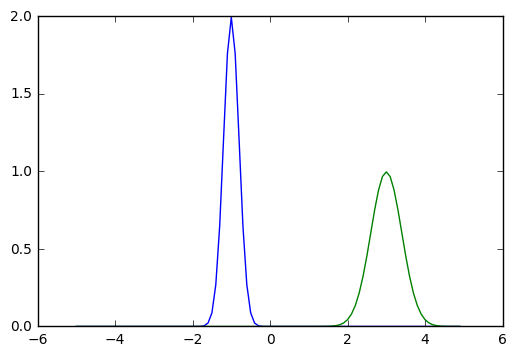

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import math

dists = [
    {'mu': -1, 'variance': 0.2},
    {'mu': 3, 'variance': 0.4}
]

X = np.arange(-5, 5, 0.1)
for v, dist in enumerate(dists):
    plt.plot(X, scipy.stats.norm.pdf(X, loc=dist['mu'], scale=dist['variance']), label='z=%s' % v)
#     plt.ylim(0, 0.1)
plt.show()

... and some points:

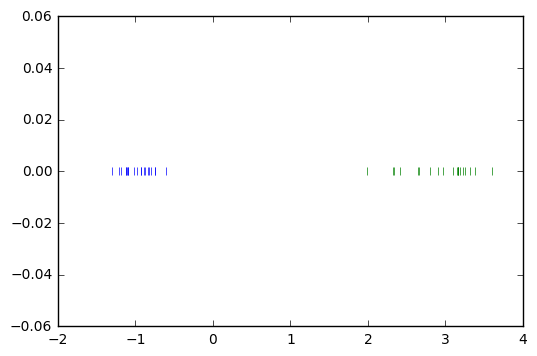

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import math

num_samples = 20
for v, dist in enumerate(dists):
    X = np.zeros((num_samples,), dtype=np.float32)
    for i in range(num_samples):
        X[i] = scipy.stats.norm.rvs(loc=dist['mu'], scale=dist['variance'])
    plt.plot(X, [0] * len(X), '|', label='z=%s' % v)
plt.show()


And we could say that $z$ is distributed for example as:

$$
P(z = 1) = 0.8
$$

And now we sample $z$ too:

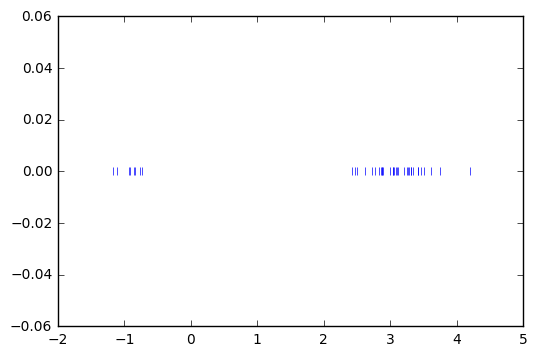

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import math

z_prob_1 = 0.8

num_samples = 40
X = np.zeros((num_samples,), dtype=np.float32)
for i in range(num_samples):
    v = np.random.choice(2, p=[1.0 - z_prob_1, z_prob_1])
    dist = dists[v]
    X[i] = scipy.stats.norm.rvs(loc=dist['mu'], scale=dist['variance'])
plt.plot(X, [0] * len(X), '|')
plt.show()


Note that we've lost the color here, though we could keep it, since during the sampling, we do in fact know the sampled values of $z$.

### Prior over $\mathbf{z}$

Then, the probability of a set of samples $\mathbf{x}$ here, where $\mathbf{x}$ is a vector, of length $N$, is... Well, we should assume we know $\mathbf{z}$, the $N$-length vector of latent values of $z$.  And lets call $P(z=1)$ $\alpha$.  Sooo... we can write down a probability distribution over $\mathbf{z}$ quite easily:

$$
p(\mathbf{z} \mid \alpha)
= \prod_{i=1}^N
\alpha^{z_i}
(1-\alpha)^{(1 - z_i)}
$$

- each of the examples where $z$ is $0$, the term in $\alpha$ evaluates to $1$, and the probability evaluates to $(1 - \alpha)$
- and each of the examples where $z$ is $1$, the term in $(1 - \alpha)$ evaluates to $1$, and the probability evaluates to $\alpha$
- ... and all of these probabilities are multiplied together

This probability distribution tells us the probability for a vector in $z$, in the absence of any knowledge of the data, but given that we know the form of the distribution, and the value of $\alpha$.

I *guess* this is a 'prior' on $\mathbf{z}$, since it is only based on knowing the form of the distribution, and a hyper-parameter, $\alpha$.

### Likelihood

Now, let's say we are given a bunch of points $\mathbf{x}$, and let's say we want to write down the probability distribution of $\mathbf{x}$ given $\mathbf{z}$, which I think is the likelihood.  Let's have the distributions:

$$
p(x \mid z=1, \mu_1, \sigma_1) = \mathcal{N}(x; \mu_1, \sigma_1)
$$
&nbsp;

$$
p(x \mid z=0, \mu_0, \sigma_0) = \mathcal{N}(\mu_0, \sigma_0)
$$

So, for one data point:

$$
p(x \mid z, \mathbf{\mu}, \mathbf{\sigma}) =
\mathcal{N}(\mu_0, \sigma_0)^{(1 - z)}
\mathcal{N}(\mu_1, \sigma_1)^{(z)}
$$

So:

- if $z$ is $1$, then $(1 - z)$ evaluates to $0$, meaning that term drops out, and we are left with the term in $\mathcal{N}(x; \mu_1, \sigma_1)$
- similarly, if $z$ is $0$, then $(z)$ evaluates to $0$, meaning that term drops out, and we are left with the term in $\mathcal{N}(x; \mu_0, \sigma_0)$

For the entire dataset, we have:

$$
p(\mathbf{x} \mid \mathbf{z}, \mathbf{\mu}, \mathbf{\sigma}) =
\prod_{i=1}^N
\mathcal{N}(x_i; \mu_0, \sigma_0)^{(1 - z_i)}
\mathcal{N}(x_i; \mu_1, \sigma_1)^{(z_i)}
$$


### Posterior for $\mathbf{z}$

Next, imagine we want to estimate the vector $z$ given $x$, so we want:

$$
P(\mathbf{z} \mid \mathbf{x})
$$

But let's nuance this slightly: let's say we know $\mu_0$, $\mu_1$, $\sigma_0$, $\sigma_1$, so we want:

$$
P(\mathbf{z} \mid \mathbf{x}, \mathbf{\sigma}, \mathbf{\mu})
$$

Using Bayes, and treating $\mathbf{\sigma}$ and $\mathbf{\mu}$ as given constants, this is:

$$
P(\mathbf{z} \mid \mathbf{x}, \mathbf{\sigma}, \mathbf{\mu})
=
\frac{p(\mathbf{x} \mid \mathbf{z}, \mathbf{\sigma}, \mathbf{\mu})\, P(\mathbf{z} \mid \mathbf{\sigma}, \mathbf{\mu})}
   {p(\mathbf{x} \mid \mathbf{\sigma}, \mathbf{\mu})}
$$


Looking at each of these terms:

#### $p(\mathbf{x} \mid \mathbf{z}, \mathbf{\sigma}, \mathbf{mu})$

We have $p(\mathbf{x} \mid \mathbf{z}, \mathbf{\sigma}, \mathbf{mu})$ from above.  It's the likelihood term.  It is a function of both $\mathbf{x}$ and $\mathbf{z}$.  Although the $\mathbf{z}$ is a conditional constant, since the conditional probability gives the distribution of $\mathbf{x}$ for many possible values of $\mathbf{z}$, any in the support of the distribution.  So it's a function of both $\mathbf{z}$ and $\mathbf{x}$.

#### $P(\mathbf{z} \mid \sigma, \mu)$

This is the prior probability of $\mathbf{z}$.  Actually we are probably missing an $\alpha$, in the conditional bit.  It should probalby look like:

$$P(\mathbf{z} \mid \alpha)$$

(and with $\sigma$ and $\mu$ removed, since they have no effect on the prior probability of $\mathbf{z}$, which we can see by re-writing down the equation:

$$
p(\mathbf{z} \mid \alpha)
= \prod_{i=1}^N
\alpha^{z_i}
(1-\alpha)^{(1 - z_i)}
$$

It is a function only of $\mathbf{z}$ and on $\alpha$.  We are finding the probability distribution of $\mathbf{z}$, conditional on $\alpha$, and both of these terms appear in the equation.  The probability distribution of $\mathbf{z}$ varies with $\alpha$.

Since this equation is conditional on $\alpha$, so, the conditional probability for $\mathbf{z}$ given $\mathbf{x}$, $\sigma$, $\mu$ should also be conditional on $\alpha$, and should look like:

$$
P(\mathbf{z} \mid \mathbf{x}, \mathbf{\sigma}, \mathbf{\mu}, \alpha)
=
\frac{p(\mathbf{x} \mid \mathbf{z}, \mathbf{\sigma}, \mathbf{\mu}, \alpha)\, P(\mathbf{z} \mid \mathbf{\alpha})}
   {p(\mathbf{x} \mid \mathbf{\sigma}, \mathbf{\mu})}
$$



So, we can see that the probability distribution for $\mathbf{z}$ is shaped by both the term $P(\mathbf{x} \mid \mathbf{z}, \mathbf{\sigma}, \mathbf{\mu}, \alpha)$ and by the term $P(\mathbf{z} \mid \alpha)$.  What about the denominator term?

#### $p(\mathbf{x} \mid \sigma, \mu)$

This is the prior distribution of $\mathbf{x}$, given $\sigma$, and $\mu$.  But we dont have this directly.  But we can get it by introducing a prior over $\alpha$, and then marginalizing over $\alpha$.  Without the prior, we have no idea what the distribution over $\mathbf{z}$ will be, so how can we calculate the probabilty of $\mathbf{x}$?  We could state that the probability of any $z$ is $0.5$, but that is in fact a prior.

### Graphical models

Let's draw a graphical model:

![](img/simple_model.png)

Then, looking at this model, if $\alpha$ is observed/known, we can write down the probaiblity of $\mathbf{z}$, given $\alpha$, ie:

$$
p(\mathbf{z} \mid \alpha)
= \prod_{i=1}^N
\alpha^{z_i}
(1-\alpha)^{(1 - z_i)}
$$

Corresponding diagram, with the variable whose probability we are writing down in red outline, and the observed variables filled in grey:

![](img/alpha_observed2.png)

If $\mathbf{z}$ is observed/known/estimated, we can write down the probability of $\mathbf{x}$, given $\mathbf{z}$, $\mathbf{\sigma}$ and $\mathbf{\mu}$, ie:

$$
p(\mathbf{x} \mid \mathbf{z}, \mathbf{\mu}, \mathbf{\sigma}) =
\prod_{i=1}^N
\mathcal{N}(x_i; \mu_0, \sigma_0)^{(1 - z_i)}
\mathcal{N}(x_i; \mu_1, \sigma_1)^{(z_i)}
$$

Corresponding diagram:

![](img/z_observed2.png)

If neither $\mathbf{z}$ or $\mathbf{x}$ are observed, but we know $\alpha$, $\sigma$ and $\mu$, then we can write down the joint probability of $\mathbf{z}$ and $\mathbf{x}$:

$$
p(\mathbf{z}, \mathbf{x} \mid \alpha, \mathbf{\omega}, \mathbf{\mu})
=
\prod_{i=1}^N
\mathcal{N}(x_i; \mu_0, \sigma_0)^{(1 - z_i)}
\mathcal{N}(x_i; \mu_1, \sigma_1)^{(z_i)}
\cdot
\prod_{i=1}^N
\alpha^{z_i}
(1-\alpha)^{(1 - z_i)}
$$

Corresponding diagram:

![](img/joint_x_z.png)

I dont think we can directly write down $p(\mathbf{x} \mid \alpha, \sigma, \mu)$, because $\mathbf{x}$ has no prior as such, unless we bring $\mathbf{z}$ in, and marginalize that.  ie, I dont think we can directly write down an expression for:

$$
p(\mathbf{x} \mid \alpha, \sigma, \mu)
$$

... but I think we can write:

$$
(\mathbf{x} \mid \alpha, \sigma, \mu) =
\int_{\mathbf{z}} p(\mathbf{x} \mid \mathbf{z}, \sigma, \mu)
\,
p(\mathbf{z} \mid \alpha)
\,
d\mathbf{z}
$$

The observed variables correspond to the joint probability diagram above, just now we only want the probability of $\mathbf{x}$, ie something like:

![](img/marginalize_z.png)


### Marginalization over $\mathbf{z}$

I guess the marginalization wont work nicely, because I guess the prior on $\mathbf{z}$ is not conjugate to the Gaussian?  Let's try, and see what happens:

$$
p(\mathbf{x} \mid \alpha, \sigma, \mu) =
\int_{\mathbf{z}}
p(\mathbf{x} \mid \mathbf{z}, \sigma, \mu)
\,
p(\mathbf{z} \mid \alpha)
\,
d\mathbf{z}
$$
&nbsp;

$$
=
\int_{\mathbf{z}}
\prod_{i=1}^N
\mathcal{N}(x_i; \mu_0, \sigma_0)^{(1 - z_i)}
\mathcal{N}(x_i; \mu_1, \sigma_1)^{(z_i)}
\cdot
\prod_{i=1}^N
\alpha^{z_i}
(1-\alpha)^{(1 - z_i)}
\,
d\mathbf{z}
$$

Note that this corresponds to marginalization of the joint probability of $\mathbf{x}$ and $\mathbf{z}$, as it should.

The latent variables, $z_i$, are independent, given $\alpha$.  And the individual data samples $x_i$ are independent, given $z_i$, $\sigma$ and $\mu$.  Actually, since the $z_i$ are independent given $\alpha$, this means I think that the $x_i$ values are independent given only $\alpha$, $\sigma$ and $\mu$?

So, we can move the product outside of hte integral, I think?

$$
=
\prod_{i=1}^N
\int_{z_i}
\mathcal{N}(x_i; \mu_0, \sigma_0)^{(1 - z_i)}
\mathcal{N}(x_i; \mu_1, \sigma_1)^{(z_i)}
\alpha^{z_i}
(1-\alpha)^{(1 - z_i)}
\,
dz_i
$$

Seems to work ok?  There is nothing inside the integral that needs knowledge of anything other than $x_i$ or $z_i$ in the $\mathbf{x}$ and $\mathbf{z}$ vectors, I think?

Let's expand the normal distribution pdfs:

$$
=
\prod_{i=1}^N
\int_{z_i}
\left(
\frac{1}{\sqrt{2\sigma_0^2\pi}}
\exp \left(
  - \frac{1}{2}
  \frac{(x_i - \mu_0}
    {\sigma_0^2}
\right)
\right)^{(1 - z_i)}
\left(
\frac{1}{\sqrt{2\sigma_1^2\pi}}
\exp \left(
  - \frac{1}{2}
  \frac{(x_i - \mu_1}
    {\sigma_1^2}
\right)
\right)^{z_i}
\alpha^{z_i}
(1-\alpha)^{(1 - z_i)}
\,
dz_i
$$

Then, following how things worked in the Griffiths and Ghahramani tutorial, for general mixture models, let's define $m_0$ and $m_1$ to be the count of $\sum_{i=1}^N \delta(z_i, 0)$ and $\sum_{i=1}^N \delta(z_i, 1)$ respectively,where $\delta(i,j)$ is Kronecker delta.  Then we have:

$$
=
\frac{1}
  {(2\pi)^{n} \sigma_0^{2m_0} \sigma_1^{2m_1}}
\prod_{i=1}^N
\int_{z_i}
\left(
\exp \left(
  - \frac{1}{2}
  \frac{(x_i - \mu_0}
    {\sigma_0^2}
\right)
\right)^{(1 - z_i)}
\left(
\exp \left(
  - \frac{1}{2}
  \frac{(x_i - \mu_1}
    {\sigma_1^2}
\right)
\right)^{z_i}
\alpha^{z_i}
(1-\alpha)^{(1 - z_i)}
\,
dz_i
$$

Hmmm.

Actually...

Each $z_i$ is discrete.  Can only have one of the values $z_i \in \{0, 1\}$.  So we can replace the integrals by sums?

$$
=
\frac{1}
  {(2\pi)^{n} \sigma_0^{2m_0} \sigma_1^{2m_1}}
\prod_{i=1}^N
\sum_{z=0}^{1}
\left(
\exp \left(
  - \frac{1}{2}
  \frac{(x_i - \mu_0}
    {\sigma_0^2}
\right)
\right)^{(1 - z)}
\left(
\exp \left(
  - \frac{1}{2}
  \frac{(x_i - \mu_1}
    {\sigma_1^2}
\right)
\right)^{z}
\alpha^{z}
(1-\alpha)^{(1 - z)}
$$

... and then split this sum/product into two parts, one for $z=0$ and one for $z=1$:

$$
=
\frac{1}
  {(2\pi)^{n} \sigma_0^{2m_0} \sigma_1^{2m_1}}
\prod_{i=1}^N
\left(
    (1-\alpha)
    \exp \left(
      - \frac{1}{2}
      \frac{(x_i - \mu_0}
        {\sigma_0^2}
    \right)
+
   \alpha
    \exp \left(
      - \frac{1}{2}
      \frac{(x_i - \mu_1}
        {\sigma_1^2}
    \right)
\right)
$$


So, the term inside the product is the sum of the probability of $z$ being 0, with the probability of a particular data point $x_i$, given $z$ is 0.  And then we add also the same thing, but for $z = 1$.  Does it makes sense to add probabilities?  In this case, we are replacing the integral for marginalization, so that seems reasonable-ish?

We got rid of the integral, and got a closed-form expression, in terms of $\mathbf{x}$, for the probability distribution over $\mathbf{x}$, assuming $\mathbf{z}$ is unobserved, but given the prior over $\mathbf{z}$, and observed $\alpha$, as well as $\mu$ and $\sigma$.

(Edit: oh, hmmm, somehow the $m_0$ and $m_1$ terms escaped, and these depend on $\mathbf{z}$, so the above analysis is wrong/incomplete.  anywya....)

### Summary of expressions so far

So we have closed-form expressions for all of:

$$
p(\mathbf{z} \mid \alpha)
= \prod_{i=1}^N
\alpha^{z_i}
(1-\alpha)^{(1 - z_i)}
$$
&nbsp;

$$
p(\mathbf{x} \mid \mathbf{z}, \mathbf{\mu}, \mathbf{\sigma}) =
\prod_{i=1}^N
\mathcal{N}(x_i; \mu_0, \sigma_0)^{(1 - z_i)}
\mathcal{N}(x_i; \mu_1, \sigma_1)^{(z_i)}
$$
&nbsp;

$$
p(\mathbf{z}, \mathbf{x} \mid \alpha, \mathbf{\omega}, \mathbf{\mu})
=
\prod_{i=1}^N
\mathcal{N}(x_i; \mu_0, \sigma_0)^{(1 - z_i)}
\mathcal{N}(x_i; \mu_1, \sigma_1)^{(z_i)}
\cdot
\prod_{i=1}^N
\alpha^{z_i}
(1-\alpha)^{(1 - z_i)}
$$
&nbsp;

$$
p(\mathbf{x} \mid \alpha, \sigma, \mu) =
\frac{1}
  {(2\pi)^{n} \sigma_0^{2m_0} \sigma_1^{2m_1}}
\prod_{i=1}^N
\left(
    (1-\alpha)
    \exp \left(
      - \frac{1}{2}
      \frac{(x_i - \mu_0}
        {\sigma_0^2}
    \right)
+
   \alpha
    \exp \left(
      - \frac{1}{2}
      \frac{(x_i - \mu_1}
        {\sigma_1^2}
    \right)
\right)
$$

I think these terms have names:

- the first one is the prior over $\mathbf{z}$
- the second is the likelihood, of $\mathbf{x}$, given the latent variables $\mathbf{z}$, and the parameters $\mu$, $\sigma$.
- the third one is the joint, but I'm not sure if it has any name more specific than that?
- the fourth one resembles a prior probability somewhat, since doesnt depend on any other variables.  I'm not sure if it can be called a prior though?  It is marginalized over the prior of $\mathbf{z}$, so it's a derived distribution. But it's still a distribution, that doesnt depend on other variables, so ... ?

### Posterior on $\mathbf{z}$

So, what we're missing is $P(\mathbf{z} \mid \mathbf{x}, \alpha, \sigma, \mu)$, which I think is the 'posterior for $\mathbf{z}$'.  We can get it by using Bayes Rule to reverse the conditional direction between $\mathbf{z}$ and $\mathbf{x}$.  We note in passing that [wikipedia](https://en.wikipedia.org/wiki/Conditional_probability) is quite clear that the conditional probability is simply defined as the joint of two variables divided by the conditioning variable.  So, by multiplying by the original conditioning variable, and dividing by a new one, we can change the direction of conditioning:

$$
P(A \mid B) = \frac{P(A,B)}{P(B)}
$$

So:

$$
P(B \mid A) = \frac{P(A,B)}{P(A)}
$$
&nbsp;

$$
P(B \mid A) = \frac{P(A \mid B)\,P(B)}{P(A)}
$$

No causality is stated or implied by the direction of conditioning.

So:
    
$$
P(\mathbf{z} \mid \mathbf{x}, \alpha, \sigma, \mu)
=
\frac{P(\mathbf{x} \mid \mathbf{z}, \alpha, \sigma, \mu)\, P(\mathbf{z} \mid \alpha, \sigma, \mu)}
  {P(\mathbf{x} \mid \alpha, \sigma, \mu)}
$$


And then, bearing in mind that the expression for $P(\mathbf{z} \mid \alpha, \sigma, \mu)$ is independent of $\sigma$ and $\mu$, and that $P(\mathbf{z} \mid \mathbf{z}, \alpha, \sigma, \mu)$ is independent of $\alpha$, so we have:

$$
P(\mathbf{z} \mid \mathbf{x}, \alpha, \sigma, \mu)
=
\frac{P(\mathbf{x} \mid \mathbf{z}, \sigma, \mu)\, P(\mathbf{z} \mid \alpha)}
  {P(\mathbf{x} \mid \alpha, \sigma, \mu)}
$$

We have closed-form expressions for each of these probability terms, so this means we also have a closed-form expression for the probability distribution of $\mathbf{z}$ given $\mathbf{x}$.

### Proportionality, revisited

As far as the proportional-to bit, which was the main thing I was pondering about originally, so basically anything on the right hand side which has terms in any $z_i$ will change the shape of the probability distribution.  Other terms will simply normalize the distribution up or down, so that it integrates to 1.

The term in the denominator $P(\mathbf{x} \mid \alpha, \sigma, \mu)$ has a closed-form expression that is independent of any $z_i$.  Its a function of $x_i$, $\alpha$, $\sigma$ and $\mu$, but there is no $z_i$ in it, since we integrated/marginalized/summed that out.  Therefore, since it doesnt contain $z_i$, it wont affect the shape of the probability distribution of $z_i$, and is a constant of normalization.  Its value will change depending on the values of $\mathbf{x}$, $\alpha$, $\sigma$ and $\mu$, to ensure the integral of the distribution sums to 1.  However, it wont actually change the shape of the probability distribution, given specific values of $\mathbf{x}$, $\alpha$, $\sigma$ and $\mu$.

So, it seems like a reasonable guideline/rule is:

- if the variable whose distribution we want is contained as either the probability variable, or a conditioning variable, in any right hand probability term, then that term should be included, even for proportionality
- otherwise, if we only want proportionality, the shape of the probability distribution, without the normalizing constnat, then we can drop any probability terms that dont contain the probabiliy variable from the left hand side, either as their probaiblity variable, or as a conditioning variable

### Form of posterior on $\mathbf{z}$

Note that, for the probability distribution of $\mathbf{z}$ conditional on $\mathbf{x}$, that:

- the numerator is just the joint, of $\mathbf{z}$ and $\mathbf{x}$, which makes sense, since the conditional of $\mathbf{z}$ on $\mathbf{x}$ is just the joint, divided by the probability of $\mathbf{x}$, the unconditional probability of $\mathbf{x}$
- the denominator is 'just' the integral of the joint.  Which makes sense, since this is exactly how we normalize a probability distribution, ie:

$$p(y) = \frac{f(y)}{\int f(y) \,dy}$$

.... for some function $f(\cdot)$ of some variable $y$.

## Interlude on Accelerated Sampling Presentation, revisited

### Basic sampling (uncollapsed)

So, let's revisit basic sampling again, start from the beginning.  This is the holistic view of basic sampling:

![](img/basicsampling_1.png)


Let's re-draw it for each sampling step, in terms of 'observed', and 'target variable'.  Where 'observed' here will mean either 'directly observed', or 'sampled from Gibbs'.  So, for $\mathbf{z}_w$ sampling we have:

- $\mathbf{A}$ is observed, from previous sampling
- $\mathbf{X}$ is observed, since it's our data
- $\mathbf{z}_{-w}$ is observed, since we use exchangeability to sample this first.  So, our observed diagram will look something like:

![](img/acceleratedsampling_zw.png)

I'm like 80% sure though, that when we sample from $\mathbf{Z}_w$ we only need $\mathbf{z}_{-w}$ and $\mathbf{x}_{w}$, since those are observed variables, and are basically Markov with respect to anything on the other side of them (not sure if the 'Markov' terminology is used correctly here?  But I think the concept is correct-ish?)

So, we will sample from:

$$
P(\mathbf{Z}_w \mid \mathbf{Z}_{-w}, \mathbf{X}_w)
$$

... and then we can use exchangeability to flip $w$ and $-w$ around, or choose another $w$, etc.  And sample from the new $\mathbf{z}_{w}$.

But what about $\mathbf{A}$?  Since $\mathbf{x}$ is observed, there is no dependence of the sampling of $\mathbf{z}$ on $\mathbf{A}$?

So, how about, maybe it's something like: technically we can sample $\mathbf{z}$ from the probability expression above.  If we have it.  However, at the start, we dont actually have an expression for it: to get the probability of $\mathbf{Z}$ given $\mathbf{X}$, we need the joint of $\mathbf{X}$ and $\mathbf{Z}$, and the marginal probability of $\mathbf{X}$.  But we have neither, yet, since both of those depend on $\mathbf{A}$.  So, we'd have to marginalize over $\mathbf{A}$ to get the above probability expression of $\mathbf{Z}$ conditioned on $\mathbf{X}$.  And marginalizing over $\mathbf{A}$ is exactly what 'collapsing' a sampler does.

So, at the base, we haven't marginalized over $\mathbf{A}$, which means initially we can write down expressions for:

$$P(\mathbf{A})$$

...given some prior on $\mathbf{A}$, and any associated hyper-parameters

and:

$$P(\mathbf{Z})$$

... given some prior on $\mathbf{Z})$ (ie, Indian Buffet Process), and any associated hyper-parameters (ie $\alpha$).

And we can write down an expression for:

$$P(\mathbf{X} \mid \mathbf{Z}, \mathbf{A})$$

... the probability of the observed data, conditonal on the latent variables.  Which I think is called the 'likelihood'.

Presumably, for Gibbs sampling, we'd want to sample from something like:

$$P(\mathbf{A} \mid \mathbf{X}, \mathbf{Z})$$

and:

$$P(\mathbf{Z} \mid \mathbf{X}, \mathbf{A})$$

Let's look at each of these in turn, not rush through Doshi-Velez's paper, and get lost :-D  So, for $\mathbf{A}$, we want:

$$P(\mathbf{A} \mid \mathbf{X}, \mathbf{Z})$$

We could sample $\mathbf{A}$ from the prior on $\mathbf{A}$.  But if we do that, then we're sampling from a distribution whch doesnt take into account the data.  It is not conditional on $\mathbf{X}$.  At the least, we'd want something like the joint of $\mathbf{X}$ and $\mathbf{A}$, divided by the marginalized probability of $\mathbf{X}$.  Or, at least, somehow get $\mathbf{X}$ into the conditioning variables.

We can get the probability of $\mathbf{A}$ conditioned on $\mathbf{X}$ by applying Bayes Rule to the likelihood:

$$P(\mathbf{X} \mid \mathbf{Z}, \mathbf{A})$$
&nbsp;
$$
=\frac
   {p(\mathbf{A} \mid \mathbf{X}, \mathbf{Z}) \, p(\mathbf{X} \mid \mathbf{Z})}
   {p(\mathbf{A} \mid \mathbf{Z})}
$$

So:

$$
p(\mathbf{A} \mid \mathbf{X}, \mathbf{Z})
=\frac
   {P(\mathbf{X} \mid \mathbf{Z}, \mathbf{A})\, p(\mathbf{A} \mid \mathbf{Z})}
   {p(\mathbf{X} \mid \mathbf{Z})}
$$

Looking at this:

- $P(\mathbf{X} \mid \mathbf{Z}, \mathbf{A})$ is the likelihood. We have this
- $p(\mathbf{X} \mid \mathbf{Z})$ is the marginalized probability of $\mathbf{X}$ given $\mathbf{Z}$.  Getting this probably involves some integration...
- $p(\mathbf{A} \mid \mathbf{Z})$ is kind of mysterious.  Looks like we'd need to marginalize over $\mathbf{X}$ to get this?  That sounds tricky...

Let's try flipping some other variables, using Bayes, and work the other way around, from what we want, trying to find stuff we know:

$$
p(\mathbf{A} \mid \mathbf{X}, \mathbf{Z})
=\frac
   {P(\mathbf{Z} \mid \mathbf{X}, \mathbf{A})\, p(\mathbf{A} \mid \mathbf{X})}
   {p(\mathbf{Z} \mid \mathbf{X})}
$$

Hmmmm.  So... this is not 'accelerated sampling', this is standard non-collapsed sampling.  So, let's find a paper about uncollapsed Gibbs sampling on an IBP.  Per the Doshi-Velez 'accelerated sampling' paper, the Griffiths and Ghahramani tutorial already covers this :-P  So, let's look back at the Griffiths and Ghahramani tutorial.

... Ok, so... initially I found nothing, but I noticed that Doshi-Velez's paper writes down $p(\mathbf{A} \mid \mathbf{X}, \mathbf{Z})$ for the case of linear-Gaussian model , equations (6) in the paper:

$$
\mu^A = \left(
  \mathbf{Z}^T \mathbf{Z} + \frac{\sigma_x^2}{\sigma_a^2}\mathbf{I}
\right)^{-1}
\mathbf{Z}^T \mathbf{X}
$$
and variance:

$$
\Sigma^A = \sigma_x^2
\left(
  \mathbf{Z}^T \mathbf{Z} + \frac{\sigma_x^2}{\sigma_a^2}\mathbf{I}
\right)^{-1}
$$

Then, looking through the section on the linear-Gaussian model in the Griffiths and Ghahramani tutorial, section 5.3 states the following expression for the expectation of $\mathbf{A}$:

$$
\mathbb{E}[\mathbf{A} \mid \mathbf{X}, \mathbf{Z}]
=
\left(
  \mathbf{Z}^T \mathbf{Z}
  +
  \frac{\sigma_X^2}{\sigma_A^2}\mathbf{I}
\right)^{-1}
  \mathbf{Z}^T\mathbf{X}
$$
... which matches the expression for the mean of $\mathbf{A}$ in the Doshi-Velez paper.

As far as how to derive this, earlier in the Griffiths and Ghahramani tutorial, section 5.1, expressions are written down for:

- $p(\mathbf{X} \mid \mathbf{Z}, \mathbf{A}, \sigma_X)$ (ie, the likelihood, I think), and
- $p(\mathbf{A} \mid \sigma_A)$ (ie the prior, on $\mathbf{A}$)

Then, these are multiplied together, to give the joint of $\mathbf{X}$ and $\mathbf{A}$, given $\mathbf{Z}$, which, just underneath equation 20 in the paper, gives an exponentiated expression involving the trace of:

$$
\frac{1}{\sigma_X^2}
(\mathbf{X}^T(\mathbf{I} - \mathbf{Z}\mathbf{M}\mathbf{Z}^T)\mathbf{X} + (\mathbf{M}\mathbf{Z}^T - \mathbf{X}  - \mathbf{A})^T (\sigma_X^2 \mathbf{M})^{-1} (\mathbf{M}\mathbf{Z}^T\mathbf{X} - \mathbf{A})
$$

... where:

$$
\mathbf{M} = (\mathbf{Z}^T\mathbf{Z} + \frac{\sigma_X^2}{\sigma_A^2}\mathbf{I})^{-1}
$$



... so the mean of this Gaussian, for $\mathbf{A}$, without thinking yet about conditioning, or marginalizing, etc, is given by:

$$
(\mathbf{M}^T\mathbf{X} - \mu_A) = 0
$$
Therefore:
$$
\mu_A = (\mathbf{Z}^T\mathbf{Z} + \frac{\sigma_X^2}{\sigma_A^2}\mathbf{I})^{-1}\mathbf{Z}^T\mathbf{X}
$$

... which matches the mean above, so seems plausibly this expression is closely related to what we need.  This expression is from inside the exponential trace of the joint of $\mathbf{A}$ and $\mathbf{X}$:

$$
p(\mathbf{X}, \mathbf{A} \mid \mathbf{Z}, \sigma_X, \sigma_A)
$$

If we want to condition on $\mathbf{X}$, we need to divide by the probability of $\mathbf{X}$, conditioned only on $\mathbf{Z}$, $\sigma_X$, and/or $\sigma_A$, but not over $\mathbf{A}$. ie:

$$
p(\mathbf{A} \mid \mathbf{X}, \mathbf{Z}, \sigma_X, \sigma_A)
= \frac{p(\mathbf{X}, \mathbf{A} \mid \mathbf{Z}, \sigma_X, \sigma_A)}
  {p(\mathbf{X} \mid \mathbf{Z}, \sigma_X, \sigma_A)}
$$

However, the denominator, $p(\mathbf{X} \mid \mathbf{Z}, \sigma_X, \sigma_A)$ does not contain the variable we are obtaining hte probaiblity distribution of, ie $\mathbf{A}$, neither as its probability varaible, nor as a conditioning variable.  Therefore the denominator is just a normalizing constant, and does not change the shape of the probability distribution in $\mathbf{A}$. Concretely, this means the denominator does not change the mean of the distribution.  We can remove the denominator, change to proportionality, and the mean of $\mathbf{A}$ will be the mean of whats left.  Whats left is the Gaussian from earlier, with the mean as stated earlier.  As proportionality, it looks like:

$$
p(\mathbf{A} \mid \mathbf{X}, \mathbf{Z}, \sigma_X, \sigma_A)
\propto p(\mathbf{X}, \mathbf{A} \mid \mathbf{Z}, \sigma_X, \sigma_A)
$$

... which has the mean required, as earlier.



So, concretely, expressed at a high-ish level, without going into the detailed Gaussians and so on, to get the distribution of $\mathbf{A}$ conditional on $\mathbf{X}$ and $\mathbf{Z}$, what we're doing is:

$$
p(\mathbf{A} \mid \mathbf{X}, \mathbf{Z}, \sigma_X, \sigma_A)
= \frac{p(\mathbf{X}, \mathbf{A} \mid \mathbf{Z}, \sigma_X, \sigma_A)}
  {p(\mathbf{X} \mid \mathbf{Z}, \sigma_X, \sigma_A)}
$$
&nbsp;

$$
p(\mathbf{A} \mid \mathbf{X}, \mathbf{Z}, \sigma_X, \sigma_A)
= \frac{ p(\mathbf{X} \mid \mathbf{A}, \mathbf{Z}, \sigma_X) \, p(\mathbf{A} \mid \sigma_A)}
  {p(\mathbf{X} \mid \mathbf{Z}, \sigma_X, \sigma_A)}
$$

$$
\propto
p(\mathbf{X} \mid \mathbf{A}, \mathbf{Z}, \sigma_X) \, p(\mathbf{A} \mid \sigma_A)
$$

.... so its basically not really using Bayes Rules, just directly using the relationship between the joint and the conditional.  Since Bayes Rule is just derived from the same relationship, but is less general, I might just try going via the joint in hte future, rahter than using Bayes Rule?

Also, note that this starts to answer my question from earlier, from just before starting to read Doshi-Velez's presentation: ie, how to handle the case when we want to sample from a distribution that is not normalized. A partial/complete answer to this question is that if our distribution is a Gaussian, we dont actually need the normalization, we can just read the mean off directly, from the exponentiated expression.

Note however that this does imply a constraint on the distributions we can use for the likelihood of $\mathbf{X}$ and the prior of $\mathbf{A}$: their product should form a distribution, in $\mathbf{A}$, whose shape is sufficient for us to be able to sample from, without needing to know its normalization.  I guess there are not so many distributions that meet this requirement?

Still, going back to the graphical model, I guess that both $\mathbf{X}$ and $\mathbf{Z}$ are observed in the expression for sampling from $\mathbf{A}$?  So, the diagram for sampling from $\mathbf{A}$ will look like? :

![](img/simple_samplea.png)

So thats strange.  I thought it was the case that when writing down probabilities from such graphs, one doesnt need to proceed further than any observed variables.  But I guess I'm wrong/have misunderstood this point somewhat?

### Collapsed sampling

Collapsed sampling was already covered in the Ghahramani tutorial.  We marginalize over $\mathbf{A}$, and can directly sample from $P(\mathbf{Z} \mid \mathbf{X})$ and/or from $P(z_nk \mid \mathbf{Z}_{-nk}, \mathbf{X})$.  In the Griffiths and Ghahramani tutorial, the expression for $P([\mathbf{Z}])$ is obtained, which is:

$$
P([\mathbf{Z}] \mid \alpha)
=
\frac{\alpha^{K_+}}
  {\prod_{h=1}^{2^N - 1}}
\cdot
\exp(-\alpha H_N
)
\cdot
\prod_{k=1}^{K_+}
\frac{(N - m_k)!(m_k-1)!}
  {N!}
$$

Should $N$ etc be in the conditioning variables?  $N$, $m_k$, $H_N$, $K^+$ are all properties that can be read directly from any specific assignment of $\mathbf{Z}$, so they are perhaps implied by $\mathbf{Z}$, and thus implicitly a part of $\mathbf{Z}$ itself?

In any case, we need to sample from:

$$P(z_{nk} \mid \mathbf{Z}_{-nk}, \mathbf{X}, \alpha)$$

We have the following known expressions, ignoring expressions in $\mathbf{A}$:

$$
P(\mathbf{X} \mid \mathbf{Z}, \theta_A)
$$

... where $\theta_A$ is any prior parameters of $\mathbf{A}$.  This expression is the likelihood.  And we have, for the IBP prior:

$$
P(z_{nk} \mid \mathbf{Z}_{-nk}, \alpha)
$$

Let's try going via the joint directly, rather than using Bayes Theorem.  Let's start by factorizing $\mathbf{Z}$ into $\{ z_{nk}, \mathbf{Z}_{-nk} \}$:

$$
P(\mathbf{X} \mid \mathbf{Z}, \theta_A)
= P(\mathbf{X} \mid z_{nk}, \mathbf{Z}_{-nk}, \theta_A)
$$

Form the joint, in terms of variables for which we have distributions, which are $\mathbf{X}$ and $z_{nk}$:

$$P(z_{nk} \mid \mathbf{Z}_{-nk}, \mathbf{X}, \alpha, \theta_A)$$
&nbsp;

$$
=
\frac{P(z_{nk}, \mathbf{X} \mid \mathbf{Z}_{-nk}, \alpha, \theta_A)}
   {p(\mathbf{X} \mid \mathbf{Z}_{-nk}, \alpha, \theta_A)}
$$

Condition on $z_{nk}$, to try to get the likelihood probability expression:

$$
=
\frac{p(\mathbf{X} \mid z_{nk}, \mathbf{Z}_{-nk}, \alpha, \theta_A) \, p(z_{nk} \mid \mathbf{Z}_{-nk}, \alpha, \theta_A)}
   {p(\mathbf{X} \mid \mathbf{Z}_{-nk}, \alpha, \theta_A)}
$$

Remove superfluous hyperparameters:

$$
=
\frac{p(\mathbf{X} \mid z_{nk}, \mathbf{Z}_{-nk}, \theta_A) \, p(z_{nk} \mid \mathbf{Z}_{-nk}, \alpha)}
   {p(\mathbf{X} \mid \mathbf{Z}_{-nk}, \theta_A, \alpha)}
$$

... but the denominator here, ie conditional probability of $\mathbf{X}$ given $\mathbf{Z}_{-nk}$, is independent of $z_{nk}$, so we can remove that as a constant of normalization:

$$
\propto
P(\mathbf{X} \mid z_{nk}, \mathbf{Z}_{-nk}, \theta_A) \, P(z_{nk} \mid \mathbf{Z}_{-nk}, \alpha)
$$

And then defactorize $\mathbf{Z}$:

$$
=
P(\mathbf{X} \mid \mathbf{Z}, \theta_A) \, P(z_{nk} \mid \mathbf{Z}_{-nk}, \alpha)
$$

.... which matches the Griffiths and Ghahramani tutorial.

### Accelerated Sampling

Let's work from the beginning of "accelerated sampling" again.  Working through the expressions in Doshi-Velez icml 2009 slides, we have:

$$
P(z_{nk} \mid \mathbf{Z}_{-nk}, \mathbf{X})
$$

Expand conditioning on $\mathbf{X}$, as division of joint by $p(\mathbf{X} \mid \dots)$:
$$
= \frac{P(z_{nk}, \mathbf{X} \mid \mathbf{Z}_{-nk})}
  {p(\mathbf{X} \mid \mathbf{Z}_{-nk})}
$$



Factorize the joint:

$$
= \frac{P(\mathbf{X} \mid z_{nk}, \mathbf{Z}_{-nk})\, P(z_{nk} \mid \mathbf{Z}_{-nk})}
  {p(\mathbf{X} \mid \mathbf{Z}_{-nk})}
$$

Merge $z_{nk}$ and $\mathbf{Z}_{-nk}$:

$$
= \frac{p(\mathbf{X} \mid \mathbf{Z})\, P(z_{nk} \mid \mathbf{Z}_{-nk})}
  {p(\mathbf{X} \mid \mathbf{Z}_{-nk})}
$$

And since denominator is independent of $z_{nk}$ convert to proportionality:

$$
\propto p(\mathbf{X} \mid \mathbf{Z})\, P(z_{nk} \mid \mathbf{Z}_{-nk})
$$

Note that the above was entirely done without reference to any "Bayes Rule" :-)  (this is different from how the slides derive this; but I like not using Bayes Rule, since not using Bayes Rule is tentatively more general, I think.)


$p(\mathbf{X} \mid \mathbf{Z})$ is a valid expression, but we cannot directly write it down: must be obtained through marginalization, over $\mathbf{A}$. Let's make the marginalization explicit:

$$
=
P(z_{nk} \mid \mathbf{Z}_{-nk})
\int_{\mathbf{A}}
p(\mathbf{X} \mid \mathbf{Z}, \mathbf{A})
\,
p(\mathbf{A})
\,
d\mathbf{A}
$$

Factorize over $n$ and $-n$.  We can do this, since the probability of each $\mathbf{x}_i$ is conditionally independent, given $\mathbf{A}$, and $\mathbf{z}_i$, and:

$$
P(\mathbf{X} \mid \mathbf{Z}, \mathbf{A})
= \prod_{i=1}^n
p(\mathbf{x}_i \mid \mathbf{z}_i, \mathbf{A})
$$
&nbsp;

$$
=
p(\mathbf{x}_n \mid \mathbf{z}_n, \mathbf{A})
\prod_{i=1}^{n-1}
p(\mathbf{x}_i \mid \mathbf{z}_i, \mathbf{A})
$$

So:
$$
P(z_{nk} \mid \mathbf{Z}_{-nk}, \mathbf{X})
$$
&nbsp;

$$
=
P(z_{nk} \mid \mathbf{Z}_{-nk})
\int_{\mathbf{A}}
p(\mathbf{x}_n \mid \mathbf{z}_n, \mathbf{A})
\,
p(\mathbf{X}_{-n} \mid \mathbf{Z}_{-n}, \mathbf{A})
\,
p(\mathbf{A})
\,
d\mathbf{A}
$$

Then Doshi-Velez combines:

$$
p(\mathbf{X}_{-n} \mid \mathbf{Z}_{-n}, \mathbf{A})\, p(\mathbf{A})
$$

into:

$$
p(\mathbf{A} \mid \mathbf{Z}_{-n}, \mathbf{X}_{-n})
$$



Let's try that in slow motion.  We have:

$$
p(\mathbf{X}_{-n} \mid \mathbf{Z}_{-n}, \mathbf{A})
\,
p(\mathbf{A})
$$

Form the joint:
$$
=
p(\mathbf{A}, \mathbf{X}_{-n} \mid \mathbf{Z}_{-n})
$$

Condition on $\mathbf{X}_{-n}$:

$$
=
p(\mathbf{A} \mid \mathbf{Z}_{-n}, \mathbf{X}_{-n})\, p(\mathbf{X}_{-n} \mid \mathbf{Z}_{-n})
$$

So, the left-hand term matches the Doshi-Velez slides. I imagine that the right-hand term vanishes into proportionality.  Things we should probably check:

- does $p(\mathbf{X}_{-n} \mid \mathbf{Z}_{-n})$ change the shape of what we are integrating over?
- ... and I guess that's sufficient?  If it doesnt change the shape of what we are integrating over, then the result of the integration should be unchanged, to within a constant of proportionality?

In any case, the term $p(\mathbf{X}_{-n} \mid \mathbf{Z}_{-n})$:

- does not contain the variable in the probability distribution we are seeking, ie $z_n$
- does not contain the variable we are integrating over, ie $\mathbf{A}$

... so that seems reasonable evidence that it wont effect the shape either of the integral, or of the entire probability distribution we are seeking?

So, remove it, in proportionality, and we have:

$$
P(z_{nk} \mid \mathbf{Z}_{-nk}, \mathbf{X}) \propto
$$
&nbsp;

$$
P(z_{nk} \mid \mathbf{Z}_{-nk})
\int_{\mathbf{A}}
p(\mathbf{x}_n \mid \mathbf{z}_n, \mathbf{A})
\,
p(\mathbf{A} \mid \mathbf{Z}_{-n}, \mathbf{X}_{-n})
\,
d\mathbf{A}
$$

... as required

I'm kind of curious how we get a posterior only conditioned on $\mathbf{Z}_{-n}$ though, so let's write down the terms in full, without doing the proportionality bit, and just look at it a bit:

$$
P(z_{nk} \mid \mathbf{Z}_{-nk}, \mathbf{X})
$$
&nbsp;

$$
=
P(z_{nk} \mid \mathbf{Z}_{-nk})
\int_{\mathbf{A}}
p(\mathbf{x}_n \mid \mathbf{z}_n, \mathbf{A})
\,
p(\mathbf{X}_{-n} \mid \mathbf{Z}_{-n}, \mathbf{A})
\,
p(\mathbf{A})
\,
d\mathbf{A}
$$
&nbsp;

$$
=
P(z_{nk} \mid \mathbf{Z}_{-nk})
\int_{\mathbf{A}}
p(\mathbf{x}_n \mid \mathbf{z}_n, \mathbf{A})
\,
p(\mathbf{A} \mid \mathbf{Z}_{-n}, \mathbf{X}_{-n})
\,
p(\mathbf{X}_{-n} \mid \mathbf{Z}_{-n})
\,
P(\mathbf{Z}_{-n})
\,
d\mathbf{A}
$$


Let's redo that term in slow motion again:

$$
p(\mathbf{X}_{-n} \mid \mathbf{Z}_{-n}, \mathbf{A})
\,
p(\mathbf{A})
$$
&nbsp;

$$
=
p(\mathbf{X}_{-n} \mid \mathbf{Z}_{-n}, \mathbf{A})
\,
p(\mathbf{A}, \mathbf{Z}_{-n} \mid \mathbf{Z}_{-n})
\,
P(\mathbf{Z}_{-n})
$$
&nbsp;

$$
=
p(\mathbf{A}, \mathbf{X}_{-n} \mid \mathbf{Z}_{-n})
\,
P(\mathbf{Z}_{-n})
$$
&nbsp;

$$
=
p(\mathbf{A} \mid \mathbf{Z}_{-n}, \mathbf{X}_{-n})
\,
p(\mathbf{X}_{-n} \mid \mathbf{Z}_{-n})
\,
P(\mathbf{Z}_{-n})
$$


Hmmm, wait.... I did:

$$
p(\mathbf{X}_{−n} \mid \mathbf{Z}_{−n}, \mathbf{A})\, p(\mathbf{A})
$$
&nbsp;

$$
=p(\mathbf{A}, \mathbf{X}_{−n} \mid \mathbf{Z}_{−n})
$$

... but that's not valid. We could only form the joint if we had:

$$
p(\mathbf{X}_{−n} \mid \mathbf{Z}_{−n}, \mathbf{A})\, p(\mathbf{A} \mid \mathbf{Z}_{-n})
$$

So, let's ponder that / redo.

~~Let's condition \mathbf{A} on \mathbf{Z}_{-n}:~~


~~p(\mathbf{X}_{−n} \mid \mathbf{Z}_{−n}, \mathbf{A})\, p(\mathbf{A})~~

~~&nbsp;~~


~~=
p(\mathbf{X}_{−n} \mid \mathbf{Z}_{−n}, \mathbf{A})\, p(\mathbf{A}, \mathbf{Z}_{-n} \mid \mathbf{Z}_{-n})\, P(\mathbf{Z}_{-n})~~

~~So, we'll get the same expression as before, just multiplied by \mathbf{Z}_{-n}, ie:~~

~~P(z_{nk} \mid \mathbf{Z}_{-nk}, \mathbf{X})\,P(\mathbf{Z}_{-n})~~

~~... but then we just make the same argument of proportionality as before.  ie, we state that \mathbf{Z}_{-n}:~~

- ~~is not the random variable in the probability distribution we are seeking, ie z_n~~
- ~~is not the variable we are integrating over, ie \mathbf{A}~~

~~... and therefore can be removed in proportionality:~~

~~\propto p(\mathbf{A} \mid \mathbf{Z}_{-n}, \mathbf{X}_{-n})~~

~~... as before~~

Let's form the joint with $\mathbf{Z}_{-n}$, to get it out of the conditioning variables:

$$
p(\mathbf{X}_{−n} \mid \mathbf{Z}_{−n}, \mathbf{A})\, p(\mathbf{A})
$$
&nbsp;

$$
=
\frac{p(\mathbf{X}_{-n}, \mathbf{Z}_{-n} \mid \mathbf{A})}
  {p(\mathbf{Z}_{-n} \mid \mathbf{A})}
p(\mathbf{A})
$$

Joint with $\mathbf{A}$:

$$
=
\frac{p(\mathbf{X}_{-n}, \mathbf{Z}_{-n}, \mathbf{A})}
  {p(\mathbf{Z}_{-n} \mid \mathbf{A})}
$$

Recondition on $\mathbf{Z}_{-n}$:

$$
=
\frac{p(\mathbf{X}_{-n}, \mathbf{A} \mid \mathbf{Z}_{-n})\, P(\mathbf{Z}_{-n})}
  {p(\mathbf{Z}_{-n} \mid \mathbf{A})}
$$

Condition on $\mathbf{X}_{-n}$:

$$
=
\frac{p(\mathbf{A} \mid \mathbf{Z}_{-n}, \mathbf{X}_{-n})\, P(\mathbf{X}_{-n} \mid \mathbf{Z}_{-n})\, P(\mathbf{Z}_{-n})}
  {p(\mathbf{Z}_{-n} \mid \mathbf{A})}
$$

The left hand term, on the numerator, is the term we want.  The other terms in the numerator are plausibly just normalization constants.  But what about that term in $\mathbf{A}$, in the denominator? That doesnt look much like a normalizing constant...

It seems like, whatever we do with it, we're still going to end up with a term in $\mathbf{A}$ somewhere from it, unlikely that the term in $\mathbf{A}$ is just going to vanish?
